In [1]:
# -*- coding: utf-8 -*-
import os 
import itertools
from __future__ import division
import numpy as np
from numpy import linalg
from numpy.random import *
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [111]:
def funk_pareto(beta,n,m,plot_boolean=False):
    # Génère un échantillon selon les paramètres
    # indiqués  (affiche un graphe)
    # beta : float, n: integer, m: integer
    s = np.random.pareto(beta, n) + m
    if(plot_boolean == True):
        count, bins, ignored = plt.hist(s, 100, normed=True)
        fit = beta*m**beta/bins**(beta+1)
        plt.plot(bins, max(count)*fit/max(fit),linewidth=2, color='r')
        plt.title(" Densite de Pareto, beta = " + str(beta))#+str(beta))
        plt.show()
    return(s)

def funk_empirical_mean(ech):
    # Calcule la moyenne empirique d'une echantillon
    #ech : list of floats
    return(np.sum(ech)/len(ech))

def funk_empirical_variance(ech):
    # Calcule la variance empirique d'un échantillon
    #ech : list of floats
    res = np.sum((ech - funk_empirical_mean(ech))**2)/len(ech)
    return(res)

def funk_sample(ech,m, rep = True):
    # Fonction réalisant un sampling
    # ech : array of float, m : int, rep : Boolean
    return(np.random.choice(ech, m, replace=rep))


def funk_bootstrap_naive(ech,B,estimateur,rep=True):
    # Donne la version bootstrap_naive d'un estimateur
    # ech : array of floats, B: int, m: int , rep : Boolean,
    # estimateur: functional
    l=[]
    m = len(ech)
    for esc in range(1,B): # B = 10
        l.append(funk_sample(ech, m, rep)) #m = 5, n = 100
    res = np.sum([estimateur(x) for x in l])/B
    return(res)

def funk_asymptot_naiv(beta,seuil,B,n,plot_call=True,vec_call = True):
    # Réalise les estimations de la moyenne  et de la variance avec bootstrap
    # beta : float, seuil: float, B: int , n: int
    # plot_call : Boolean, vec_call : Boolean
    l_emp , v_emp , l_boot , v_boot = [],[],[],[]
    for esc in range(B,n):
        ech = funk_pareto(beta,n,seuil)
        l_emp.append(funk_empirical_mean(ech))
        v_emp.append(funk_empirical_variance(ech))
        l_boot.append(funk_bootstrap_naive(ech,B,funk_empirical_mean))
        v_boot.append(funk_bootstrap_naive(ech,B,funk_empirical_variance))
    if((plot_call == True) ):
        f, axarr = plt.subplots(2, 2)
        axarr[0, 0].hist(l_emp)
        axarr[0, 0].set_title('Empirical Mean')
        axarr[0, 1].hist(v_emp)
        axarr[0, 1].set_title('Empirical Var')
        axarr[1, 0].hist(l_boot)
        axarr[1, 0].set_title('Boot mean')
        axarr[1, 1].hist(v_boot)
        axarr[1, 1].set_title('Boot Var')
        plt.tight_layout()
    if(vec_call == True):
        return([l_emp,v_emp,l_boot,v_boot])
    
def funk_boot_strap_dist(ech,thresh,B,estimateur,plot_call=False):
    # génére une prob  et outil pour la fonction de répartition
    # ech : array of float, thresh : float, B : int
    l=[]
    m = len(ech)
    mean_emp = funk_empirical_mean(ech)
    for esc in range(B):
        l.append(estimateur(funk_sample(ech,m,len(ech))))
    res = np.sum([1 if (np.sqrt(m)*(x - mean_emp) < thresh) else 0 for x in l])/B
    if(plot_call == True):
        thresh = np.linspace(-1, 1, num=100)
        plt.figure()
        plt.plot(thresh,[funk_boot_strap_dist(ech,x,B,estimateur) for x in thresh])
        plt.title(" Fonction de repartition bootstrap ")
        plt.ylim(0,1.2)
        plt.xlim(min(thresh)-0.1,max(thresh)+0.1)
        plt.show()
    return(res)

def funk_denomb(n,m):
    # Calcule le nombre "m parmi n"
    # m: int, n : int
    fact = lambda z : reduce(lambda x,y:x*y,range(1,z+1),1)
    return(fact(n)/(fact(m)*fact(n-m)))

def funk_bootstrap_outof(ech,m,estimateur):
    # Fonction bootstrapant "m out of n" pour un estimateur
    #ech : array of float, m: int
    n = len(ech)
    thresh = funk_denomb(n,m)
    if(thresh< 5000000):
        s = set(ech)
        test = map(list, itertools.combinations(s, m))
        return(np.sum([estimateur(x) for x in test])/len(test))        
    else:
        print("Denombrement trop large")

def funk_bootstrap_outof_dist(ech,m,estimateur,xi,plot_call = False):
    # Fonction bootstrapant "m out of n" pour un estimateur
    # ech : array of float, m: int , estimateur : function, xi :float
    # plot_call : Boolean
    n = len(ech)
    thresh = funk_denomb(n,m)
    emp_estimateur =estimateur(ech)
    if(thresh< 3000000):
        s = set(ech)
        test = map(list, itertools.combinations(s, m))
        test = [np.sqrt(m)*(estimateur(x)-emp_estimateur) for x in test]
        test = np.sum([1 if (x < xi) else 0 for x in test])/len(test)
        if(plot_call == True):
            thresh = np.linspace(-.1, 0.3, num=100)
            plt.figure()
            plt.plot(thresh,[funk_bootstrap_outof_dit(ech,m,estimateur,x) for x in thresh])
            plt.title(" Fonction de repartition bootstrap m_outof_n")
            plt.ylim(0,1.2)
            plt.xlim(min(thresh)-0.1,max(thresh)+0.1)
            plt.show()

        return(test)
    else:
        print("Denombrement trop large")
        
def funk_boot_strap_dist_normalized(ech,thresh,estimateur,B,plot_call=False):
    # génére une prob  et outil pour la fonction de répartition
    # Version normalisée
    # ech : array of float, thresh : float, B : int, estimateur : function
    # plot_call : Boolean
    l=[]
    l_v=[]
    m = len(ech)
    mean_emp = estimateur(ech)
    for esc in range(B):
        tes_pass = funk_sample(ech,m,len(ech))
        l.append(estimateur(tes_pass))
        l_v.append(funk_empirical_variance(tes_pass))
    res = np.sum([1 if (np.sqrt(m)*(l[x] - mean_emp)/np.sqrt(l_v[x]) < thresh) else 0 for x in range(len(l))])/len(l)
    if(plot_call == True):
        thresh = np.linspace(-1, 1, num=100)
        plt.figure()
        plt.plot(thresh,[funk_boot_strap_dist_normalized(ech,x,estimateur,B) for x in thresh])
        plt.title(" Fonction de repartition bootstrap normalized")
        plt.ylim(0,1.2)
        plt.xlim(min(thresh)-0.1,max(thresh)+0.1)
        plt.show()
    return(res)

def funk_bootstrap_outof_dist_normalized(ech,m,estimateur,xi,plot_call = False):
    # Fonction bootstrapant "m out of n" pour un estimateur
    # Version normalisée
    # ech : array of float, m: int, estimateur : function, xi : flot
    # plot_call : Boolean
    n = len(ech)
    thresh = funk_denomb(n,m)
    emp_estimateur =estimateur(ech)
    if(thresh< 3000000):
        s = set(ech)
        test = map(list, itertools.combinations(s, m))
        test = [np.sqrt(m)*(estimateur(test[x])-emp_estimateur)/np.sqrt(funk_empirical_variance(test[x]))
                for x in range(len(test))]
        test = np.sum([1 if (x < xi) else 0 for x in test])/len(test)
        if(plot_call == True):
            thresh = np.linspace(-1, 1, num=100)
            plt.figure()
            plt.plot(thresh,[funk_bootstrap_outof_dist_normalized(ech,m,estimateur,x) for x in thresh])
            plt.title(" Fonction de repartition bootstrap m_outof_n normalized")
            plt.ylim(0,1.2)
            plt.xlim(min(thresh)-0.1,max(thresh)+0.1)
            plt.show()
        return(test)
    else:
        print("Denombrement trop large")
        
def funk_beta_moment(ech,seuil):
    # Méthode des moments pour Beta
    # ech : array of float, seuil : float
    mean = funk_empirical_mean(ech)
    return(mean/(mean-seuil))
def funk_beta_mle(ech,seuil):
    # Méthode MLE pour Beta
    # ech : array of float, seuil : float
    return(1/((1/len(ech))*np.sum(np.log((1/seuil)*ech))))

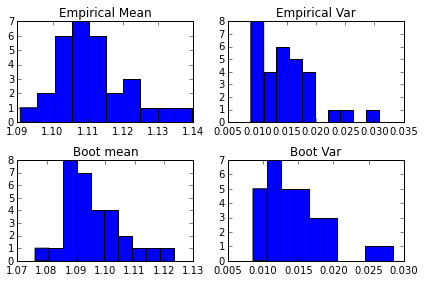

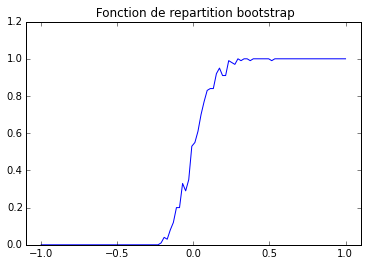

1.0

In [59]:
beta = 10 
seuil = 1
B = 70
n = 100
echantillon = funk_pareto(beta,n,seuil,plot_boolean=False)
l = funk_asymptot_naiv(beta,seuil,B,n)

m = np.round(n/5)
n = 30
beta = 10 
seuil = 1
echantillon = funk_pareto(beta,n,seuil)
mean_emp = funk_empirical_mean(echantillon)
funk_boot_strap_dist(echantillon,1,100,funk_empirical_mean,plot_call=True)

### Estimateur centré et réduit

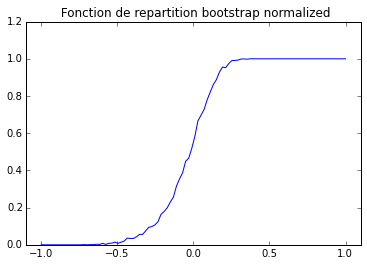

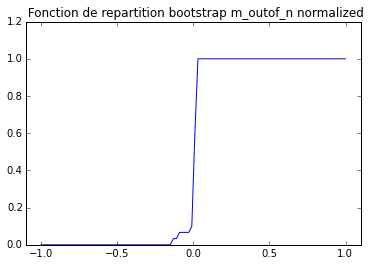

1.0

In [108]:

m = np.round(n/5)
n = 30
beta = 10 
seuil = 1
echantillon = funk_pareto(beta,n,seuil)
mean_emp = funk_empirical_mean(echantillon)
funk_boot_strap_dist_normalized(echantillon,0.5,funk_empirical_variance,1000,plot_call=True)
funk_bootstrap_outof_dist_normalized(echantillon,29,funk_empirical_variance,0.1,plot_call=True)